# **TP CLUSTERING**

**Note** : This notebook is not our report, but just contains our practical work on Clustering Methods. Here we show how we produced different figures. We also reused the text written in our report for each part's description. More details are figured in our report. 

## **0.Import libraries**

In [0]:
## Run this bloc in your terminal in case of 
# ! pip install hdbscan       ##  to download hdbscan module
# ! pip install liac-arff     ##  to read .arff files 

In [0]:
from scipy.io import arff
import pandas as pd

import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from itertools import cycle, islice

from hdbscan import HDBSCAN
# from sklearn.datasets import make_blobs

np.random.seed(10)

## **1.Prepare dataset**

In [0]:
## Git clone this
# ! git clone https://github.com/deric/clustering-benchmark

In [0]:
datapath = '/content/clustering-benchmark/src/main/resources/datasets/artificial/'

## **2.Define core functions**

We define this core function in ordrer to apply more easily different clustering method in the upcoming blocs of this notebook. 
Parameters of this function:

* ***dataname*** : available on https://github.com/deric/clustering-benchmark 
* ***algo*** : {kmeans, agglo, dbscan, hdbscan}
* ***params*** : using a dict variable, default is *None* 
* ***verbose*** : set *True* if you want to plot the result, default is *None*

In [0]:
def run_clustering_with(dataname='2d-4c-no4.arff',algo='kmeans',params=None, verbose=False):
    ## ======================================
    ## Load dataset
    ## ======================================
    data,_ = arff.loadarff( datapath + dataname)
    df = pd.DataFrame(data)

    ## ======================================
    ## Export data from dataframe
    ## ======================================
    X =  df.iloc[:,0:2].values

    ## ======================================
    ## Scale / Normalize data
    ## ======================================
    X = StandardScaler().fit_transform(X)

    ## ======================================
    ## Create a cluster model
    ## ======================================
    if algo == 'kmeans':
        if params == None:
            clustering = KMeans()
        else:
            clustering = KMeans(n_clusters = params['n_clusters'],
                                init = params['init'])
    elif algo == 'agglo':
        if params == None:
            clustering = AgglomerativeClustering()
        else:
            clustering = AgglomerativeClustering(n_clusters = params['n_clusters'], 
                                                 linkage = params['linkage'])  
    elif algo == 'dbscan' :
        if params == None : 
            clustering = DBSCAN()
        else : 
            clustering = DBSCAN(min_samples = params['min_samples'], eps = params['eps'])
      
    elif algo == 'hdbscan' :
        if params == None : 
            clustering = HDBSCAN()
        else : 
            clustering = HDBSCAN(min_cluster_size = int(params['min_cluster_size']),
                                 min_samples = int(params['min_samples']))
            
    ## ======================================
    ## Predict and compute execution time
    ## ======================================
    t0 = time.time()
    y_pred = clustering.fit_predict(X)
    t1 = time.time()
    runtime = t1 - t0
    ## ======================================
    ## Compute silhouette score
    ## ======================================
    # sil_score = silhouette_score(X,y_pred,metric='euclidean')

    # if algo=='kmeans':
    #     ## Compute inertia score
    #     score = -clustering.score(X)
    #     print('Inertia objective = ', score)

    ## ======================================
    ## Scatter plot the result
    ## ======================================
    if verbose:
        plt.scatter(X[:,0],X[:,1],c=y_pred) 
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        # plt.xticks(())
        # plt.yticks(())
        plt.text(.99,.01, ('%.2fs')%runtime,
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'right')
        # plt.title("Clustering with " + algo +  " applied on" + dataname + "\n Silhouette score = %.2f, Execution time : %.2fs" % (sil_score,t1-t0) )
   
    return clustering, X, y_pred, runtime

## **3.Explore K-Means : Centroid-based clustering**

### **a. What is its best use cases?**


This algorithm optimizes cluster centers instead of cluster borders, so it prefers clusters with approximately similar size ***(1)***. Furthermore, the distance metric used in k-means algorithm is the squared Euclidean distance, hence it is very good at identifying clusters with flat geometry, particularly with a spherical shape. Additionally, the official documents state that “the inertia makes the assumption that clusters are convex and isotropic”, so it might not perform well with clusters with irregular shapes ***(2)***. Moreover, even when a dataset does not satisfy the two previous conditions, K-Means can still perform on that dataset if their clusters are very well separated, thanks to "k-means++" which initializes centroids by choosing starting points that are very far from each other ***(3)***. For all of these reasons, we deduce k-means clustering’s best use case, which include the following properties : 
* ***(1)*** => The dataset has even cluster size
* ***(2)*** => It has flat geometry which contains well convex shapes
* ***(3)*** => It should be very well separated


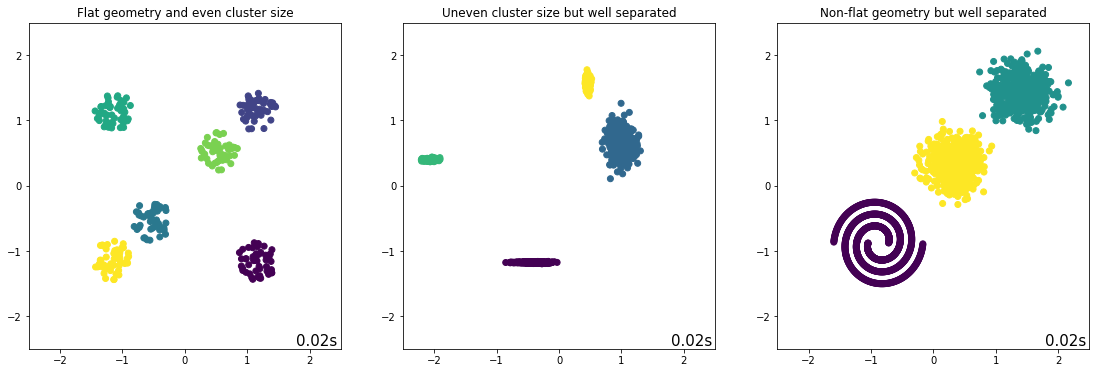

In [0]:
plt.figure(figsize=(19,6))

ax1 = plt.subplot(131)
params_kmeans = {"n_clusters":6,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='spherical_6_2.arff', algo='kmeans', params=params_kmeans,verbose=True) 
ax1.set_title("Flat geometry and even cluster size")

ax2 = plt.subplot(132) 
params_kmeans = {"n_clusters":4,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='2d-4c.arff', algo='kmeans', params=params_kmeans,verbose=True) 
ax2.set_title("Uneven cluster size but well separated")

ax3= plt.subplot(133) 
params_kmeans = {"n_clusters":3,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='2sp2glob.arff', algo='kmeans', params=params_kmeans,verbose=True) 
ax3.set_title("Non-flat geometry but well separated")

plt.show()

### **b. How to choose the best k value?**
K-Means Clustering has only one important parameter - the number of clusters K - explains why it is relatively simple to implement. But in some cases, the choice of K value might not be obvious, and it will be required to verify the clustering quality

In [0]:
k_settings = np.arange(2,11,1)
sil_scores, inertia_losses, runtimes = [], [], []
for k in k_settings:
    params_kmeans = {"n_clusters":k,"init":"k-means++"} 
    clustering,X,y_pred,exec_time = run_clustering_with(dataname='spherical_5_2.arff', algo='kmeans', params=params_kmeans)
    sil_scores.append(silhouette_score(X,y_pred,metric='euclidean'))
    inertia_losses.append(-clustering.score(X))
    runtimes.append(exec_time)

best_n_clusters = k_settings[np.argmax(sil_scores)]
print("Best nb of clusters dealing with this dataset is :", best_n_clusters)

Best nb of clusters dealing with this dataset is : 5


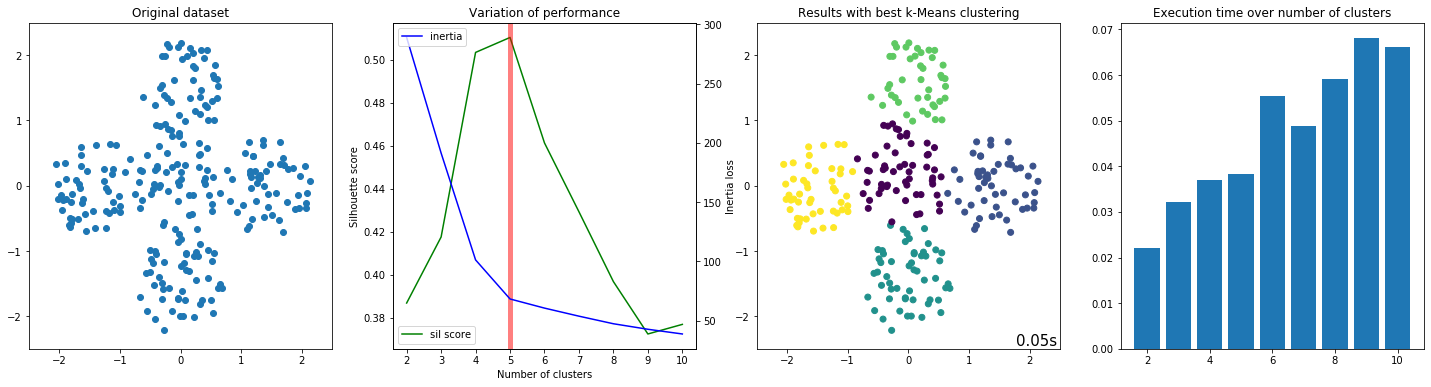

In [0]:
plt.figure(figsize=(25,6))

ax1 = plt.subplot(141)
ax1.scatter(X[:,0],X[:,1])
ax1.set_xlim(-2.5,2.5)
ax1.set_ylim(-2.5,2.5)
ax1.set_title('Original dataset')

ax2 = plt.subplot(142)
ax2.plot(k_settings, sil_scores,c='g',label='sil score')
ax2.set_ylabel('Silhouette score')
ax2.set_xlabel('Number of clusters')
ax2.set_title('Variation of performance')
ax2.axvline(x=best_n_clusters,linewidth=5,alpha=0.5,color='r')    
ax2.legend(loc=3)
ax2_2 = ax2.twinx()
ax2_2.plot(k_settings, inertia_losses,c='b',label='inertia')
ax2_2.set_ylabel('Inertia loss')
ax2_2.legend(loc=2)

ax3 = plt.subplot(143)
params_kmeans = {"n_clusters":best_n_clusters,"init":"k-means++"} 
_,X,_,_ = run_clustering_with(dataname='spherical_5_2.arff', algo='kmeans', params=params_kmeans,verbose=True)
ax3.set_title('Results with best k-Means clustering')

ax4 = plt.subplot(144)
ax4.bar(k_settings, runtimes)
ax4.set_title("Execution time over number of clusters")

# plt.title('Find best k for diamond dataset with k-means')
plt.show()

### **c. Limits of K-Means?**
The fact that K-Means Clustering requires to specify the number of clusters is considered as a drawback : in most of real life use cases, the number of clusters is not evident, so it might take efforts to find the optimal K value, and a poor choice of K value will provide a poor result. Moreover, since real-world datasets often contain many noisy points and the algorithm searches iteratively for a centroid, noise will also be considered in the calculation and distorts the final result. Moreover, since K value has a direct impact on the algorithm’s complexity, this method will scale well on dataset with too many clusters.
In summary, K-Means clustering does not perform very well in case of :
* Non-flat geometry
* Uneven cluster size
* Data with noise samples
* Too many cluster => Increase complexity 

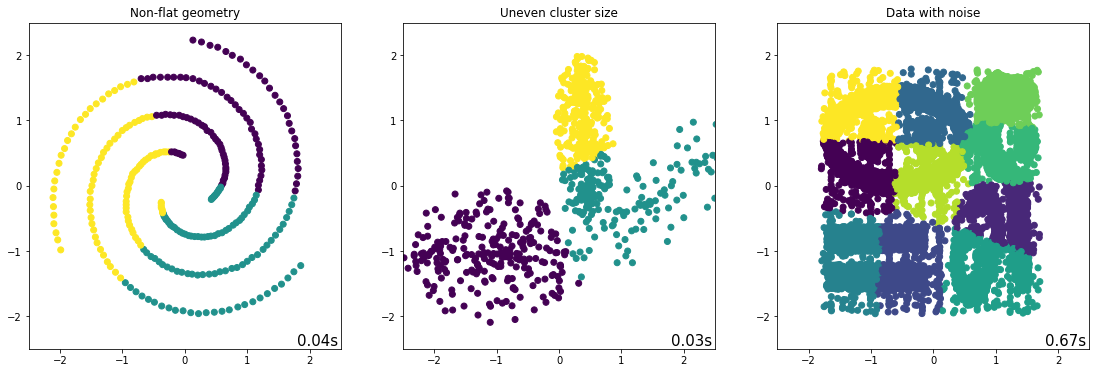

In [0]:
plt.figure(figsize=(19,6))

ax1 = plt.subplot(131)
params_kmeans = {"n_clusters":3,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='3-spiral.arff', algo='kmeans', params=params_kmeans,verbose=True) 
ax1.set_title("Non-flat geometry")

ax2 = plt.subplot(132) 
params_kmeans = {"n_clusters":3,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='2d-3c-no123.arff', algo='kmeans', params=params_kmeans,verbose=True)  #cure-t0-2000n-2D
ax2.set_title("Uneven cluster size")

ax3= plt.subplot(133) 
params_kmeans = {"n_clusters":10,"init":"k-means++"} 
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='kmeans', params=params_kmeans,verbose=True) 
ax3.set_title("Data with noise")

plt.show()

## **4.Explore Agglomerative Clustering : Connectivity-based (Hierarchical) clustering**

Through the first section, we have familiarized with the K-Means Clustering technique which relies heavily on dataset’s convexity because of its nature of optimizing centers. That said, since data might not always have a regular shapes where k-means clustering express its best performance, this method performs poorly on datasets with irregular shape. 


### **a. How can it overcome K-Means' limits?**
Firstly, agglomerative clustering can be used comfortably in case of any number of clusters, as this parameters are only used to determine the suitable cut on the dendrogram without affecting the hierarchy tree’s quality as well as the overall complexity. Furthermore, regarding the approach of iteratively linking every two points or two small clusters, this method performs very well on data with uneven cluster size ***(4)***. However, the execution time will be exponentially high on large dataset, but this problem can be addressed by adding a connectivity constraint that will boost remarkably the computation speed ***(5)***. Moreover, with different linkage parameter, agglomerative clustering can be employed with any pairwise distance metric, thus works well on even dataset with non-flat geometry ***(6)***. 
Hence, we deduce the potentially best use case for Agglomerative clustering: 
* ***(4)*** => the dataset has uneven cluster size 
* ***(5)*** => it has a possible connectivity constraint
* ***(6)*** => it is eventually non-convex

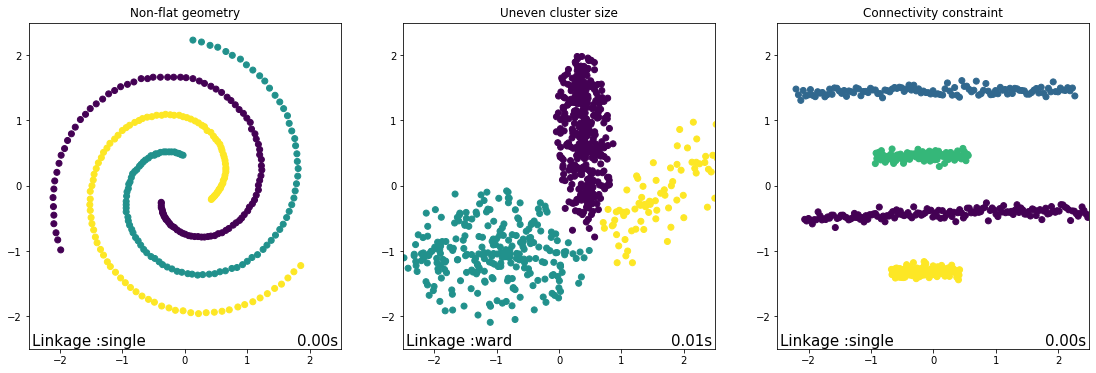

In [0]:
plt.figure(figsize=(19,6))

ax1 = plt.subplot(131)
params_agglo = {"n_clusters":3,"linkage":"single"} 
_,_,_,_ = run_clustering_with(dataname='3-spiral.arff', algo='agglo', params=params_agglo,verbose=True) 
ax1.set_title("Non-flat geometry")
ax1.text(.01,.01, "Linkage :" + params_agglo["linkage"],
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

ax2 = plt.subplot(132) 
params_agglo = {"n_clusters":3,"linkage":"ward"}
_,_,_,_ = run_clustering_with(dataname='2d-3c-no123.arff', algo='agglo', params=params_agglo,verbose=True) 
ax2.set_title("Uneven cluster size")
ax2.text(.01,.01, "Linkage :" + params_agglo["linkage"],
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

ax3= plt.subplot(133) 
params_agglo = {"n_clusters":4,"linkage":"single"}
_,_,_,_ = run_clustering_with(dataname='zelnik5.arff', algo='agglo', params=params_agglo,verbose=True) 
ax3.set_title("Connectivity constraint")
ax3.text(.01,.01, "Linkage :" + params_agglo["linkage"],
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

plt.show()

### **b. Why Agglomerative clustering is better than K-Means in case of many clusters?**

Since the number of clusters have no impact on algorithm’s complexity, it might provide a better execution time compared to k-means if the dataset has many clusters.


In [0]:
k_settings = np.arange(2,41,1)
kmean_runtimes, agglo_runtimes = [], []
for k in k_settings:
    params_kmeans = {"n_clusters":k,"init":"k-means++"} 
    _,X,_,kmeans_exec_time = run_clustering_with(dataname='fourty.arff', algo='kmeans', params=params_kmeans)
    kmean_runtimes.append(kmeans_exec_time)

    params_agglo = {"n_clusters":k,"linkage":"ward"} 
    _,X,_,agglo_exec_time = run_clustering_with(dataname='fourty.arff', algo='agglo', params=params_agglo)
    agglo_runtimes.append(agglo_exec_time)

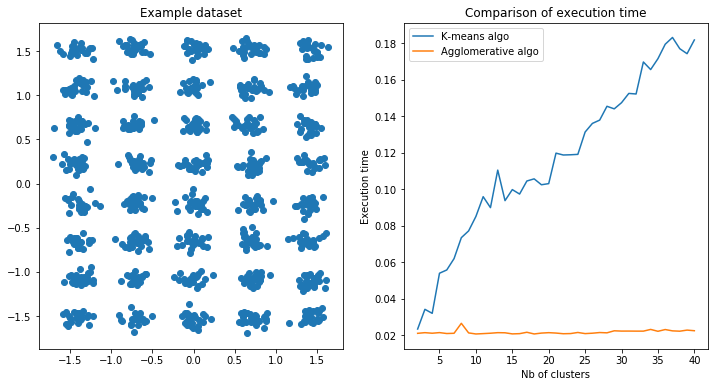

In [0]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1])
plt.title("Example dataset")
plt.subplot(122)
plt.plot(k_settings, kmean_runtimes, label='K-means algo')
plt.plot(k_settings, agglo_runtimes, label='Agglomerative algo')
plt.legend(loc='best')
plt.xlabel('Nb of clusters')
plt.ylabel('Execution time')
plt.title("Comparison of execution time")
plt.show()

### **c. How to choose the best linkage in Agglomerative Clustering?**

Actually there are four well-known linkages methods, each having their own use cases, which are : 
* ***Single*** linkage, which considers the shortest distance between pair of clusters, so it tends to produce long, loose, non globular clusters, but very sensible to noise.
* ***Complete*** linkage, which considers the longest distance between pair of clusters, so it tends to produce more compact clusters, but still sensible to noise. 
* ***Average*** linkage, which considers the mean distance between all pairs of points, so it produces more homogeneous clusters, also it is less sensible to noise.
* ***Ward***, which seeks to minimizes the total within-cluster variance, so it aims for clusters which are more dense and more concentric towards its middle.



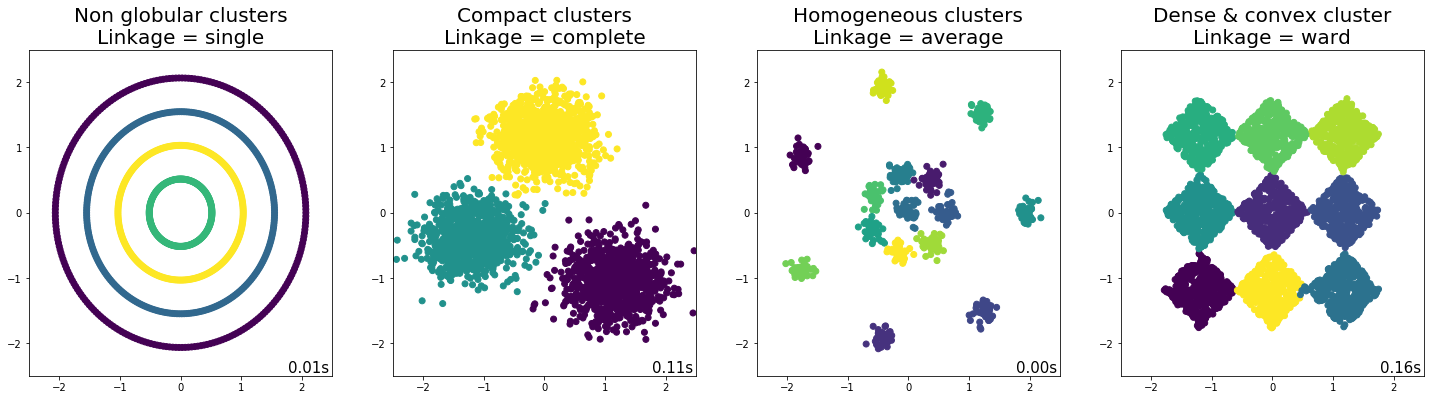

In [0]:
plt.figure(figsize=(25,6))

ax1 = plt.subplot(141)
params_agglo = {"n_clusters":4,"linkage":"single"} 
_,_,_,_ = run_clustering_with(dataname='dartboard1.arff', algo='agglo', params=params_agglo,verbose=True) 
ax1.set_title("Non globular clusters\nLinkage = " + params_agglo["linkage"],fontsize=20)

ax2 = plt.subplot(142) 
params_agglo = {"n_clusters":3,"linkage":"complete"}
_,_,_,_ = run_clustering_with(dataname='xclara.arff', algo='agglo', params=params_agglo,verbose=True) 
ax2.set_title("Compact clusters\nLinkage = " + params_agglo["linkage"],fontsize=20)

ax3= plt.subplot(143) 
params_agglo = {"n_clusters":15,"linkage":"average"}
_,_,_,_ = run_clustering_with(dataname='R15.arff', algo='agglo', params=params_agglo,verbose=True) 
ax3.set_title("Homogeneous clusters\nLinkage = " + params_agglo["linkage"],fontsize=20)

ax4= plt.subplot(144) 
params_agglo = {"n_clusters":9,"linkage":"ward"}
_,_,_,_ = run_clustering_with(dataname='diamond9.arff', algo='agglo', params=params_agglo,verbose=True) 
ax4.set_title("Dense & convex cluster\nLinkage = " + params_agglo["linkage"],fontsize=20)

plt.show()

### **d. Limits of Agglomerative Clustering**

Firstly, the algorithm does not support backtracking, which means it cannot undo an unsatisfactory linking between two points or two clusters. Furthermore, this method does not scale well on large dataset because of its time complexity by the approach of trying to merge every data points together until it obtains a hierarchy tree. That is why, without a connectivity constraint, it will show a very long execution time. 

Also, even with different linkage available, Agglomerative Clustering is still sensitive to outliers, so it is not a good method to clustering dataset with noise. Let's plot some figures to demonstrate this problem :



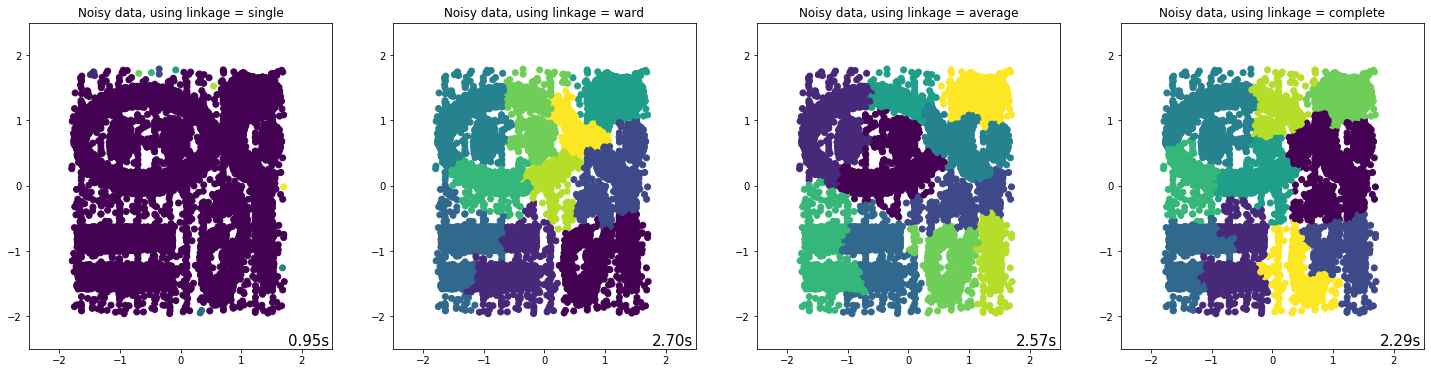

In [0]:
plt.figure(figsize=(25,6))

ax1 = plt.subplot(141)
params_agglo = {"n_clusters":10,"linkage":"single"} 
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='agglo', params=params_agglo,verbose=True) 
ax1.set_title("Noisy data, using linkage = " + params_agglo["linkage"])

ax2 = plt.subplot(142) 
params_agglo = {"n_clusters":10,"linkage":"ward"}
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='agglo', params=params_agglo,verbose=True) 
ax2.set_title("Noisy data, using linkage = " + params_agglo["linkage"])

ax3= plt.subplot(143) 
params_agglo = {"n_clusters":10,"linkage":"average"}
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='agglo', params=params_agglo,verbose=True) 
ax3.set_title("Noisy data, using linkage = " + params_agglo["linkage"])

ax4= plt.subplot(144) 
params_agglo = {"n_clusters":10,"linkage":"complete"}
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='agglo', params=params_agglo,verbose=True) 
ax4.set_title("Noisy data, using linkage = " + params_agglo["linkage"])

plt.show()

## **5.Explore DBSCAN : Density-based clustering**

### **a. Can this method deal with noises ?**
This method aims to separate clusters of high density from clusters of lower density, so clusters found by DBSCAN can be any shape ***(7)***. Furthermore, the way this algorithm find cluster based on density defined by the range eps  and the minimal number of points within the range min_samples make it independant to the number of clusters, as well as clusters size ***(8)***. Above all, DBSCAN provides a robust approach to deal with outliers/anomalies within the dataset ***(9)***.

In brief, we deduce here an use case that can show the ultimate power of DBSCAN :  
- ***(7)*** => the dataset has favorably a non-flat geometry
- ***(8)*** => it has uneven cluster size
- ***(9)*** => it contains noises

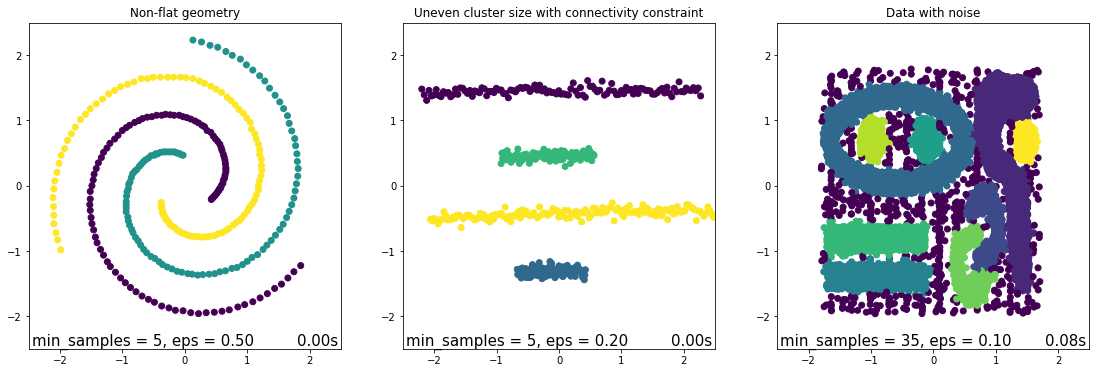

In [0]:
plt.figure(figsize=(19,6))

ax1 = plt.subplot(131)
params_dbscan = {"min_samples":5,"eps":0.5} 
_,_,_,_ = run_clustering_with(dataname='3-spiral.arff', algo='dbscan', params=params_dbscan,verbose=True) 
ax1.set_title("Non-flat geometry")
ax1.text(.01,.01, "min_samples = %d, eps = %.2f" % (params_dbscan["min_samples"],params_dbscan["eps"]),
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

ax2 = plt.subplot(132) 
params_dbscan = {"min_samples":5,"eps":0.2} 
_,_,_,_ = run_clustering_with(dataname='zelnik5.arff', algo='dbscan', params=params_dbscan,verbose=True) 
ax2.set_title("Uneven cluster size with connectivity constraint")
ax2.text(.01,.01, "min_samples = %d, eps = %.2f" % (params_dbscan["min_samples"],params_dbscan["eps"]),
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

ax3= plt.subplot(133) 
params_dbscan = {"min_samples":35,"eps":0.1} 
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='dbscan', params=params_dbscan,verbose=True) 
ax3.set_title("Data with noise")
ax3.text(.01,.01, "min_samples = %d, eps = %.2f" % (params_dbscan["min_samples"],params_dbscan["eps"]),
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

plt.show()

### **b. How to choose the best parameters when dealing with noises?**

DBSCAN requires two parameters : ***eps** and ***min_samples***. 


* ***min_samples*** controls how tolerant the algorithm is towards noise => it is recommended to choose a large value to effectively deal with large dataset or dataset with noises, which will form more significant clusters. 

 


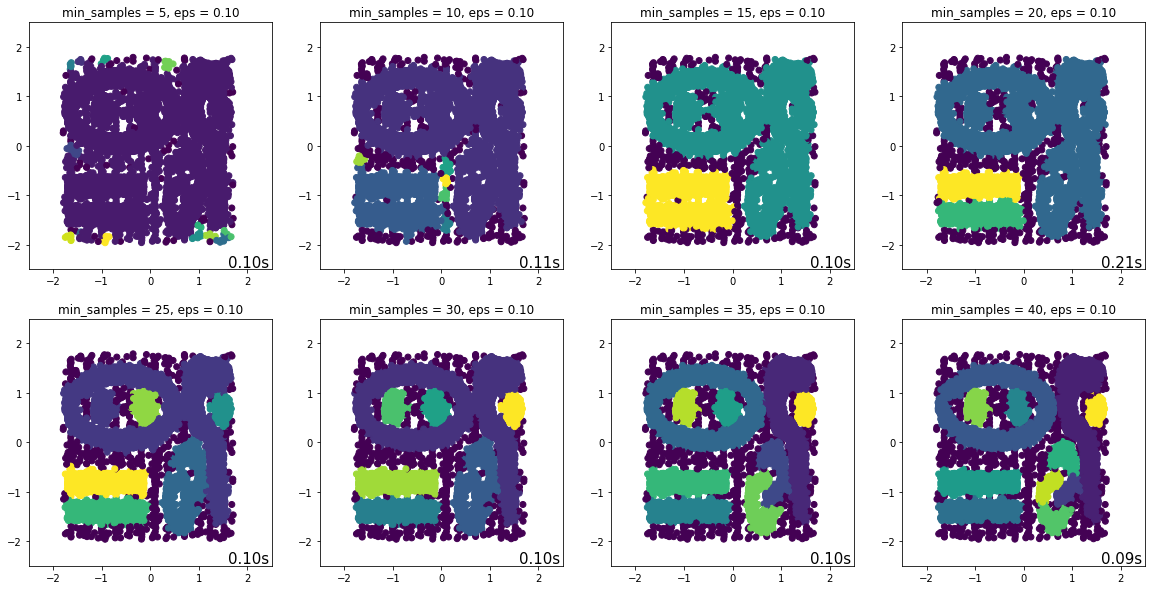

In [0]:
plt.figure(figsize=(20,10))
nplot=1
for i in range (5, 41, 5):
    ax = plt.subplot(2,4,nplot)
    params_dbscan = {"min_samples": i , "eps":0.1}
    _,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='dbscan', params=params_dbscan,verbose=True) 
    ax.title.set_text("min_samples = " + str(i) + ", eps = %.2f" % params_dbscan["eps"])
    nplot+=1
plt.show()

* ***eps*** control the local neighborhood of the points, so crucial that it can be deterministic for the distinction between clusters and outliers => As with a too small eps, a large part of the data will not be clustered, thus considered as noise; and with a too large eps, clusters will merge and the majority of objects will be in the same cluster

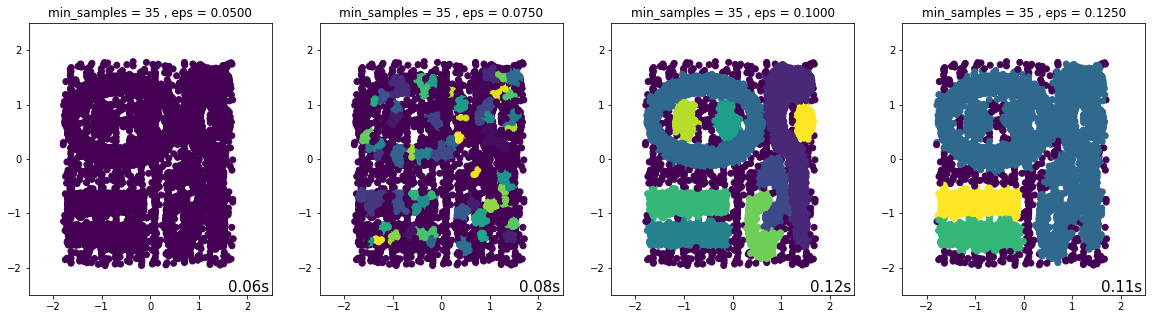

In [0]:
plt.figure(figsize=(20,5))
nplot=1
eps = 0.025
for i in range (2,6):    
    ax = plt.subplot(1,4,nplot)
    params_dbscan = {"min_samples": 35 , "eps":eps*i}
    _,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='dbscan', params=params_dbscan,verbose=True) 
    ax.title.set_text("min_samples = %d , eps = %.4f" % (params_dbscan["min_samples"],params_dbscan["eps"]))
    nplot+=1
plt.show()

### **c. Limits of DBSCAN Clustering**
DBSCAN is a robust clustering technique against dataset with noise. But it still has a serious drawback. The fact that the core distance eps need to be specified and stay constant throughout the execution makes the algorithm struggle to dataset with ***variable density***.

(-3, 3)

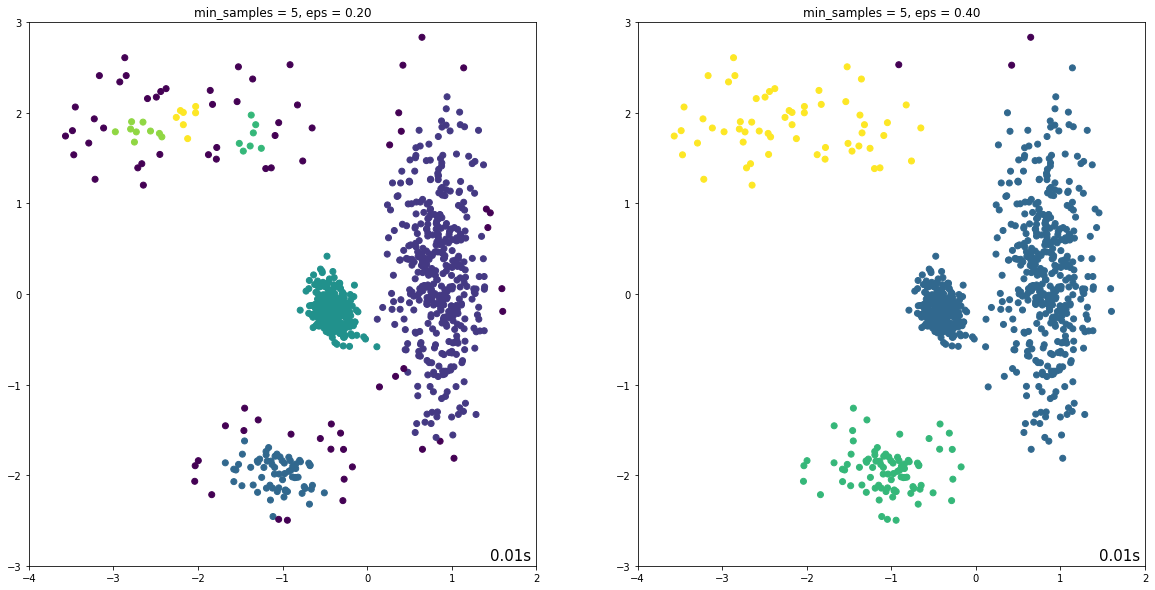

In [0]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(121)
params_dbscan = {"min_samples":5,"eps":0.2} 
_,_,_,_ = run_clustering_with(dataname='2d-4c-no4.arff', algo='dbscan', params=params_dbscan,verbose=True) 
ax1.title.set_text("min_samples = %d, eps = %.2f" % (params_dbscan["min_samples"],params_dbscan["eps"]))
ax1.set_xlim(-4,2)
ax1.set_ylim(-3,3)

ax2 = plt.subplot(122)
params_dbscan = {"min_samples":5,"eps":0.4} 
_,_,_,_ = run_clustering_with(dataname='2d-4c-no4.arff', algo='dbscan', params=params_dbscan,verbose=True) 
ax2.title.set_text("min_samples = %d, eps = %.2f" % (params_dbscan["min_samples"],params_dbscan["eps"]))
ax2.set_xlim(-4,2)
ax2.set_ylim(-3,3)

## **6.Explore HDBSCAN : An extension of DBSCAN**


### **a. Is it better than DBSCAN?**
“Hierarchical DBSCAN” comes as the extended solution to address aforementioned problem. It improves DBSCAN by adding the hierarchical clustering approach into the density clustering, then uses a technique to extract a flat clustering based on the stability of clusters.


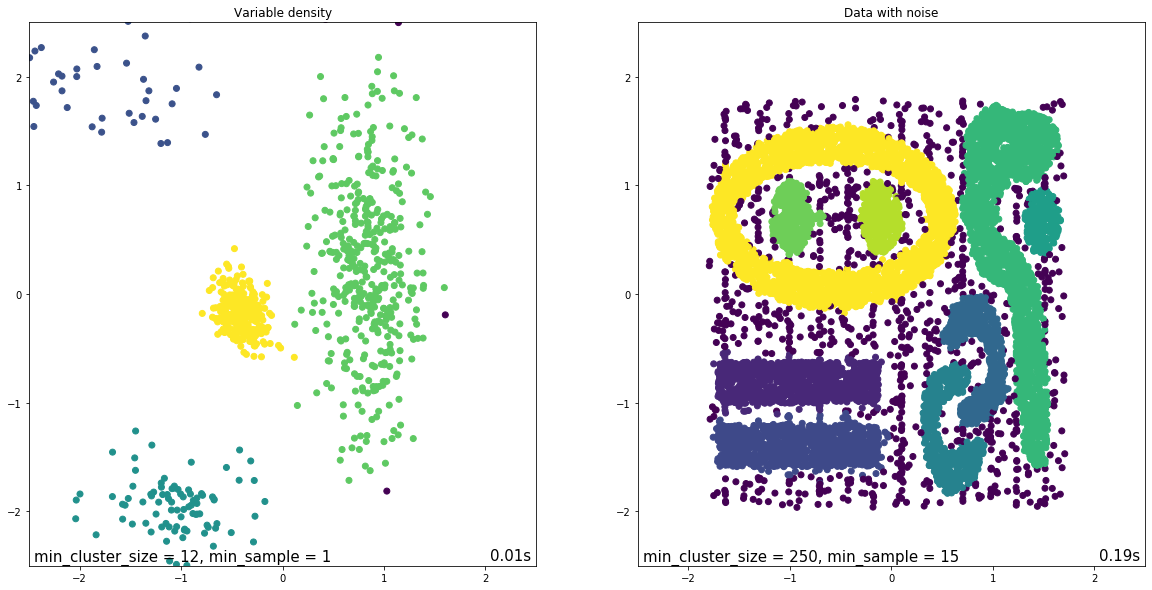

In [0]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(121)
params_hdbscan = {"min_cluster_size":12,"min_samples":1} 
_,_,_,_ = run_clustering_with(dataname='2d-4c-no4.arff', algo='hdbscan', params=params_hdbscan,verbose=True) 
ax1.set_title("Variable density")
ax1.text(.01,.01, "min_cluster_size = %d, min_sample = %d" % (params_hdbscan["min_cluster_size"],params_hdbscan["min_samples"]),
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

ax2= plt.subplot(122) 
params_hdbscan = {"min_cluster_size":250,"min_samples":15} 
_,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='hdbscan', params=params_hdbscan,verbose=True) 
ax2.set_title("Data with noise")
ax2.text(.01,.01, "min_cluster_size = %d, min_sample = %d" % (params_hdbscan["min_cluster_size"],params_hdbscan["min_samples"]),
                    transform = plt.gca().transAxes, size = 15,
                    horizontalalignment = 'left')

plt.show()

### **b. How to choose the best parameters?**
HDBSCAN has two important parameters which are min_cluster_size and min_samples contributed a relatively complex role to the algorithm:
* ***min_cluster size*** defines the smallest size grouping that we wish to consider a cluster
* ***min samples*** provides a measure of how conservative the clustering will be, with larger the value will result in more points declared as noise, and clusters will be restricted to progressively more dense areas. 


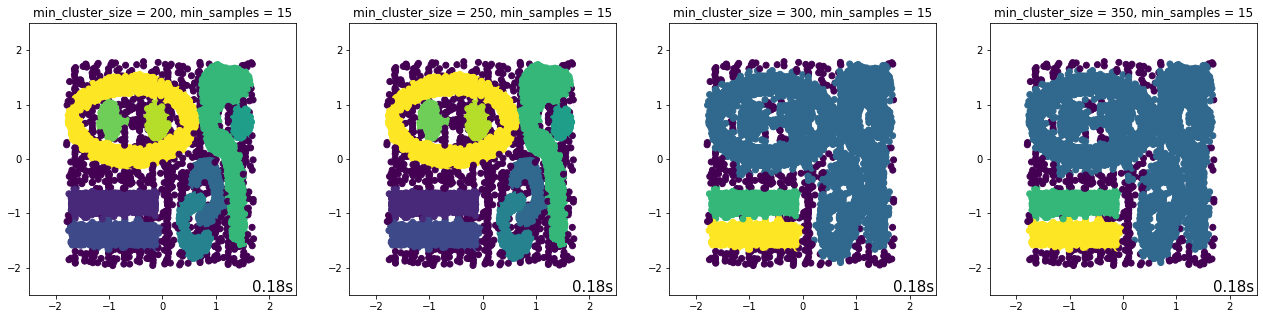

In [0]:
# Fix min_samples
plt.figure(figsize=(22,5))
nplot=1
for i in range (200, 400, 50):
    ax = plt.subplot(1,4,nplot)
    params_hdbscan = {"min_cluster_size":i,"min_samples":15} 
    _,_,_,_ = run_clustering_with(dataname='cluto-t7-10k.arff', algo='hdbscan', params=params_hdbscan,verbose=True) 
    ax.title.set_text("min_cluster_size = %d, min_samples = %d" % (params_hdbscan["min_cluster_size"],params_hdbscan["min_samples"]))
    nplot+=1
plt.show()

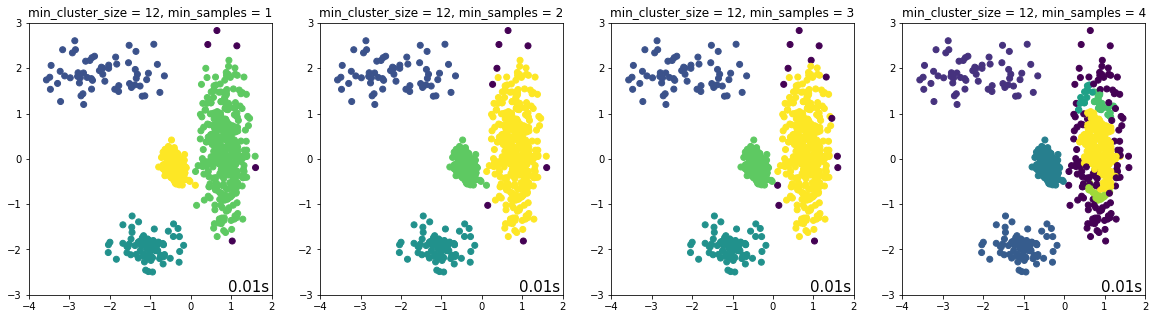

In [0]:
## Fix min_cluster_size
plt.figure(figsize=(20,5))
nplot=1
for i in range (1, 5, 1):
    ax = plt.subplot(1,4,nplot)
    params_hdbscan = {"min_cluster_size":12,"min_samples":i} 
    _,_,_,_ = run_clustering_with(dataname='2d-4c-no4.arff', algo='hdbscan', params=params_hdbscan,verbose=True) 
    ax.title.set_text("min_cluster_size = %d, min_samples = %d" % (params_hdbscan["min_cluster_size"],params_hdbscan["min_samples"]))
    ax.set_xlim(-4,2)
    ax.set_ylim(-3,3)
    nplot+=1
plt.show()

## **7.Comparison of all above implemented methods on different datasets**

At the end of our practical work, we wish to carry out a comparison between four studied methods. So we decided to apply all four clustering techniques on each one’s best use case. This way, we can have a panorama view of studied techniques, by observing their similarities/differences regarding their behaviour on different datasets.

**Chosen datasets :** 

* xclara : even cluster size, convex, well separated, similar density, less noise
* 3-spiral : even cluster size, non-convex, well separated, similar density, no noise
* cluto-t7-10k : uneven cluster size, non convex, similar density, with noise
* 2d-4c-no4 : uneven cluster size, convex, variable density, no noise

In [0]:
spherical_data,_ = arff.loadarff('/content/clustering-benchmark/src/main/resources/datasets/artificial/xclara.arff')
nonconvex_data,_ = arff.loadarff('/content/clustering-benchmark/src/main/resources/datasets/artificial/3-spiral.arff')
noise_data,_ = arff.loadarff('/content/clustering-benchmark/src/main/resources/datasets/artificial/cluto-t7-10k.arff')
vaden_data,_ = arff.loadarff('/content/clustering-benchmark/src/main/resources/datasets/artificial/2d-4c-no4.arff')

In [0]:
spherical_df = pd.DataFrame(spherical_data)
nonconvex_df = pd.DataFrame(nonconvex_data)
noise_df = pd.DataFrame(noise_data)
vaden_df = pd.DataFrame(vaden_data)

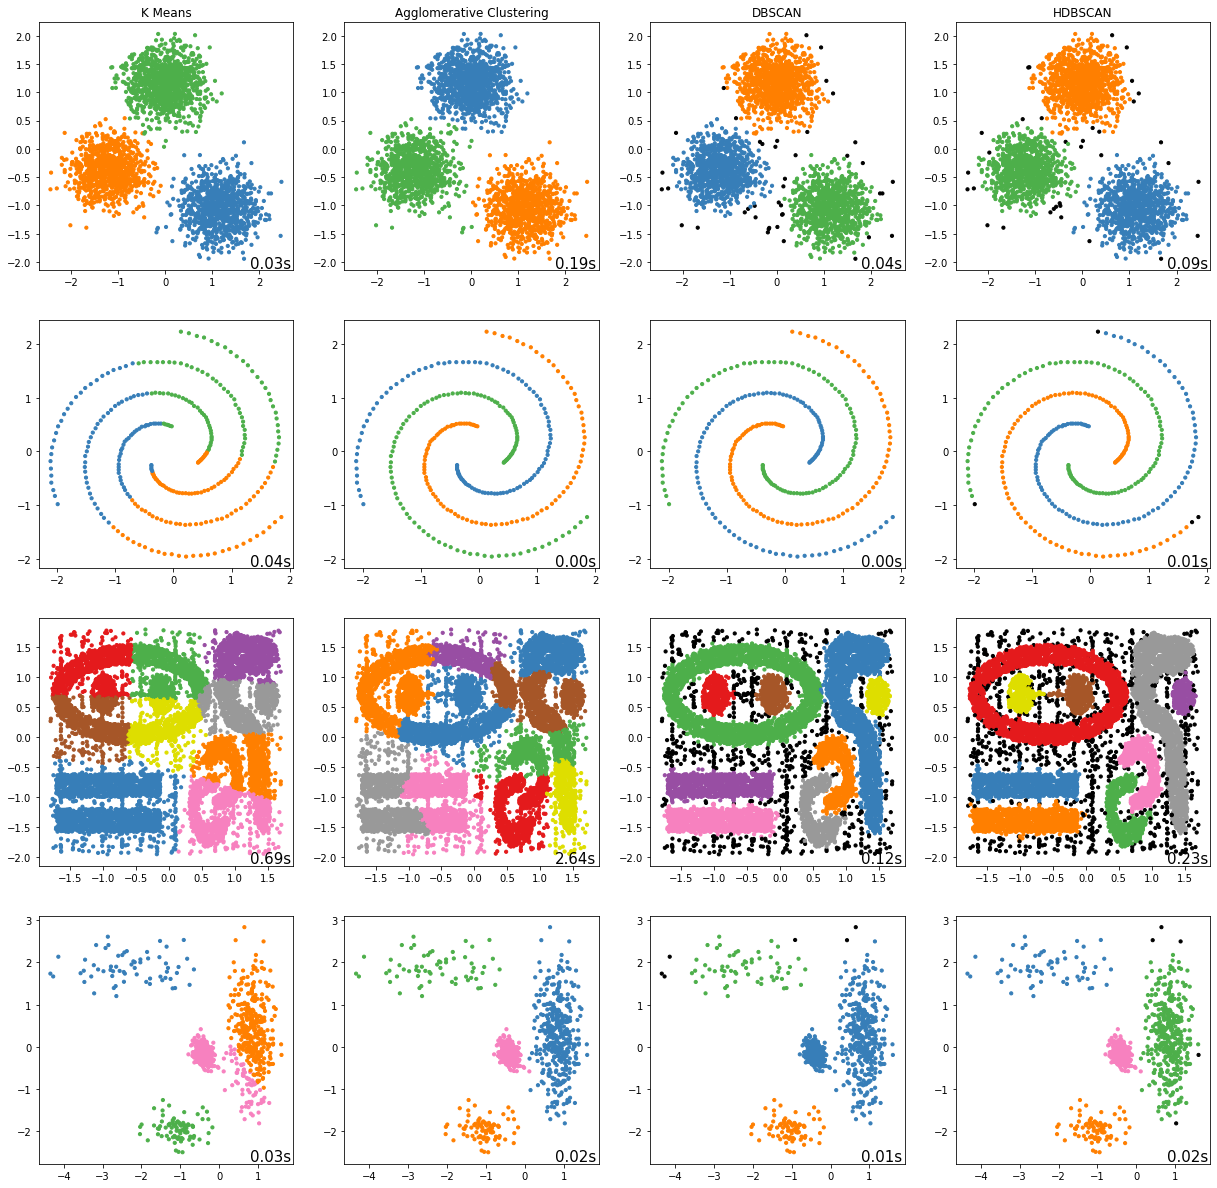

In [0]:
# list of data set without param configs
datasets = [(spherical_df, {"n_clusters":3,"linkage":"ward", "min_samples_dbscan": 10,"eps":0.2, "min_cluster_size":30, "min_samples_hdbscan":2}),
            (nonconvex_df, {"n_clusters":3,"linkage":"single", "min_samples_dbscan": 5,"eps":0.5, "min_cluster_size":10, "min_samples_hdbscan":5}),
            (noise_df, {"n_clusters":10,"linkage":"average", "min_samples_dbscan": 35,"eps":0.1, "min_cluster_size":35, "min_samples_hdbscan":5}),
            (vaden_df, {"n_clusters":4,"linkage":"ward", "min_samples_dbscan": 5,"eps":0.4, "min_cluster_size":12, "min_samples_hdbscan":1})]


plt.figure(figsize=(21, 21))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
plot_num = 1

# ===================
# Iterate over all chosen datasets
# ===================
for i_ds, (dataset,params) in enumerate(datasets):
    
    # ===================
    # Load & Normalize data
    # ===================
    X =  dataset.iloc[:,0:2].values
    X = StandardScaler().fit_transform(X)


    # ===================
    # Create cluster models
    # ===================
    kmeans = KMeans(n_clusters=params["n_clusters"], init="k-means++")
    dbscan = DBSCAN(min_samples=params["min_samples_dbscan"], eps=params["eps"])
    agglo = AgglomerativeClustering(n_clusters=params["n_clusters"], linkage=params["linkage"])
    hdbscan = HDBSCAN(min_cluster_size=params["min_cluster_size"], min_samples=params["min_samples_hdbscan"])

    clustering_algos = ((kmeans,'K Means'),
                        (agglo, 'Agglomerative Clustering'),
                        (dbscan,'DBSCAN'),
                        (hdbscan, 'HDBSCAN'))

    # ===================
    # Run each algo for each dataset
    # ===================
    for algo, name_algo in clustering_algos : 
        
        # ===================
        # Fit model and predict
        # ===================
        t0 =  time.time()
        y_pred = algo.fit_predict(X)
        t1 = time.time()

        # ===================
        # PLOT GRAPHS
        # ===================
        plt.subplot(len(datasets),len(clustering_algos),plot_num)
        
        # add title of each applied algo
        if i_ds == 0:
          plt.title(name_algo)

        # set colors for each cluster
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        # scatter plot with color for different clusters and outliers (if any) 
        plt.scatter(X[:,0],X[:,1],s=10, color=colors[y_pred])
        # plt.xlim(-2.5,2.5)
        # plt.ylim(-2.5,2.5)
        # plt.xticks(())
        # plt.yticks(())
        plt.text(.99,.01, ('%.2fs')%(t1-t0),
                 transform = plt.gca().transAxes, size = 15,
                 horizontalalignment = 'right')
        plot_num += 1

        # ===================
        # End
        # ===================
plt.show()

-------------
# **END OF NOTEBOOK**


------------


